# Определение перспективного тарифа для телеком-компании
**Описание проекта**  
Вы аналитик компании «Мегалайн» — федерального оператора сотовой связи. Клиентам предлагают два тарифных плана: «Смарт» и «Ультра». Чтобы скорректировать рекламный бюджет, коммерческий департамент хочет понять, какой тариф приносит больше денег.  
Вам предстоит сделать предварительный анализ тарифов на небольшой выборке клиентов. В вашем распоряжении данные 500 пользователей «Мегалайна»: кто они, откуда, каким тарифом пользуются, сколько звонков и сообщений каждый отправил за 2018 год. Нужно проанализировать поведение клиентов и сделать вывод — какой тариф лучше.

**Описание тарифов**  

**_Тариф «Смарт»_**  
* Ежемесячная плата: 550 рублей
* Включено 500 минут разговора, 50 сообщений и 15 Гб интернет-трафика
* Стоимость услуг сверх тарифного пакета: 
    1. минута разговора: 3 рубля («Мегалайн» всегда округляет вверх значения минут и мегабайтов. Если пользователь проговорил всего 1 секунду, в тарифе засчитывается целая минута); 
    2. сообщение: 3 рубля; 3. 1 Гб интернет-трафика: 200 рублей.

**_Тариф «Ультра»_**  
* Ежемесячная плата: 1950 рублей
* Включено 3000 минут разговора, 1000 сообщений и 30 Гб интернет-трафика
* Стоимость услуг сверх тарифного пакета: 
    1. минута разговора: 1 рубль; 
    2. сообщение: 1 рубль; 
    3. 1 Гб интернет-трафика: 150 рублей.

_Примечание:_  
«Мегалайн» всегда округляет секунды до минут, а мегабайты — до гигабайт. Каждый звонок округляется отдельно: даже если он длился всего 1 секунду, будет засчитан как 1 минута.  
Для веб-трафика отдельные сессии не считаются. Вместо этого общая сумма за месяц округляется в бо́льшую сторону. Если абонент использует 1025 мегабайт в этом месяце, с него возьмут плату за 2 гигабайта.  

## Изучение данных из файла

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from scipy import stats as st

In [2]:
df_calls = pd.read_csv("/datasets/calls.csv")
df_calls.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
id           202607 non-null object
call_date    202607 non-null object
duration     202607 non-null float64
user_id      202607 non-null int64
dtypes: float64(1), int64(1), object(2)
memory usage: 6.2+ MB


In [3]:
df_internet = pd.read_csv("/datasets/internet.csv")
df_internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 entries, 0 to 149395
Data columns (total 5 columns):
Unnamed: 0      149396 non-null int64
id              149396 non-null object
mb_used         149396 non-null float64
session_date    149396 non-null object
user_id         149396 non-null int64
dtypes: float64(1), int64(2), object(2)
memory usage: 5.7+ MB


In [4]:
df_messages = pd.read_csv("/datasets/messages.csv")
df_messages.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
id              123036 non-null object
message_date    123036 non-null object
user_id         123036 non-null int64
dtypes: int64(1), object(2)
memory usage: 2.8+ MB


In [5]:
df_tariffs = pd.read_csv("/datasets/tariffs.csv")
df_tariffs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
messages_included        2 non-null int64
mb_per_month_included    2 non-null int64
minutes_included         2 non-null int64
rub_monthly_fee          2 non-null int64
rub_per_gb               2 non-null int64
rub_per_message          2 non-null int64
rub_per_minute           2 non-null int64
tariff_name              2 non-null object
dtypes: int64(7), object(1)
memory usage: 256.0+ bytes


In [6]:
df_users = pd.read_csv("/datasets/users.csv")
df_users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
user_id       500 non-null int64
age           500 non-null int64
churn_date    38 non-null object
city          500 non-null object
first_name    500 non-null object
last_name     500 non-null object
reg_date      500 non-null object
tariff        500 non-null object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB


In [7]:
df_calls.head()

,id,call_date,duration,user_id
0,1000_0,2018-07-25,0.00,1000
1,1000_1,2018-08-17,0.00,1000
2,1000_2,2018-06-11,2.85,1000
3,1000_3,2018-09-21,13.80,1000
4,1000_4,2018-12-15,5.18,1000


In [8]:
df_internet.head()

,Unnamed: 0,id,mb_used,session_date,user_id
0,0,1000_0,112.95,2018-11-25,1000
1,1,1000_1,1052.81,2018-09-07,1000
2,2,1000_2,1197.26,2018-06-25,1000
3,3,1000_3,550.27,2018-08-22,1000
4,4,1000_4,302.56,2018-09-24,1000


In [9]:
df_messages.head()

,id,message_date,user_id
0,1000_0,2018-06-27,1000
1,1000_1,2018-10-08,1000
2,1000_2,2018-08-04,1000
3,1000_3,2018-06-16,1000
4,1000_4,2018-12-05,1000


In [10]:
df_tariffs.head()

,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


In [11]:
df_users.head()

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1001,41,NaN,Москва,Иван,Ежов,2018-11-01,smart
2,1002,59,NaN,Стерлитамак,Евгений,Абрамович,2018-06-17,smart
3,1003,23,NaN,Москва,Белла,Белякова,2018-08-17,ultra
4,1004,68,NaN,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra


## Подготовка данных

### Обработка пропусков и преобразование типов данных

* Приведите данные к нужным типам;
* Найдите и исправьте ошибки в данных, если они есть.
  * Поясните, какие ошибки вы нашли и как их исправили. В данных вы найдёте звонки с нулевой продолжительностью. Это не ошибка: нулями обозначены пропущенные звонки, поэтому их не нужно удалять.

#### df_calls

Посмотрим число пропусков в таблице df_calls

In [12]:
df_calls.isna().sum()

id           0
call_date    0
duration     0
user_id      0
dtype: int64

Преобразуем значения столбца call_date в тип datetime

In [13]:
df_calls['call_date'].describe()

count         202607
unique           365
top       2018-12-31
freq            1435
Name: call_date, dtype: object

In [14]:
df_calls['call_date'] = pd.to_datetime(df_calls['call_date'], format="%Y-%m-%d")
df_calls['call_date'].describe()

count                  202607
unique                    365
top       2018-12-31 00:00:00
freq                     1435
first     2018-01-01 00:00:00
last      2018-12-31 00:00:00
Name: call_date, dtype: object

Округлим значения продолжительности разговора в большую сторону

In [15]:
df_calls['duration'] = df_calls['duration'].apply(np.ceil).astype(int)
df_calls['duration'].describe()

count    202607.000000
mean          7.158198
std           5.959173
min           0.000000
25%           2.000000
50%           6.000000
75%          11.000000
max          38.000000
Name: duration, dtype: float64

#### df_internet

In [16]:
df_internet.isna().sum()

Unnamed: 0      0
id              0
mb_used         0
session_date    0
user_id         0
dtype: int64

Изучим столбец Unnamed: 0

In [17]:
df_internet['Unnamed: 0'].describe()

count    149396.000000
mean      74697.500000
std       43127.054745
min           0.000000
25%       37348.750000
50%       74697.500000
75%      112046.250000
max      149395.000000
Name: Unnamed: 0, dtype: float64

In [18]:
len(df_calls[df_calls['id'].isna()])

0

Кажется, этот стобец дублирует номера строк датафрейма, можно его удалить

In [19]:
df_internet = df_internet.drop(columns = ['Unnamed: 0'],axis = 1)

In [20]:
df_internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 entries, 0 to 149395
Data columns (total 4 columns):
id              149396 non-null object
mb_used         149396 non-null float64
session_date    149396 non-null object
user_id         149396 non-null int64
dtypes: float64(1), int64(1), object(2)
memory usage: 4.6+ MB


Преобразуем значения столбца session_date в тип datetime

In [21]:
df_internet['session_date'].describe()

count         149396
unique           365
top       2018-12-31
freq            1057
Name: session_date, dtype: object

In [22]:
df_internet['session_date'] = pd.to_datetime(df_internet['session_date'], format="%Y-%m-%d")
df_internet['session_date'].describe()

count                  149396
unique                    365
top       2018-12-31 00:00:00
freq                     1057
first     2018-01-01 00:00:00
last      2018-12-31 00:00:00
Name: session_date, dtype: object

In [23]:
df_internet['mb_used'].describe()

count    149396.000000
mean        370.192426
std         278.300951
min           0.000000
25%         138.187500
50%         348.015000
75%         559.552500
max        1724.830000
Name: mb_used, dtype: float64

Выясним общий процент нулевых интернет-сессий

In [24]:
(100 * df_internet.loc[df_internet['mb_used'] == 0, 'mb_used'].count() / df_internet['mb_used'].count()).round(2)

13.12

Составим сводную таблицу с количеством нулевых сессий, общим числом сессий и их соотношением

In [25]:
df_internet.loc[df_internet['mb_used'] == 0, 'mb_null'] = True

null_ratio = df_internet.pivot_table(
    index='user_id',
    values='mb_null',
    aggfunc='count').reset_index()\
.merge(df_internet.pivot_table(
    index='user_id',
    values='mb_used',
    aggfunc='count').reset_index(),
       on=['user_id'], how='outer')

null_ratio['ratio'] = (100 * null_ratio['mb_null'] / null_ratio['mb_used']).round(2)

null_ratio.head()

,user_id,mb_null,mb_used,ratio
0,1000,14,211,6.64
1,1001,14,96,14.58
2,1002,72,369,19.51
3,1003,2,104,1.92
4,1004,22,300,7.33


Получим сводную статистику по столбцу

In [26]:
null_ratio['ratio'].describe().round(2)

count    497.00
mean      12.58
std        5.69
min        0.00
25%        6.17
50%       14.61
75%       16.85
max       25.00
Name: ratio, dtype: float64

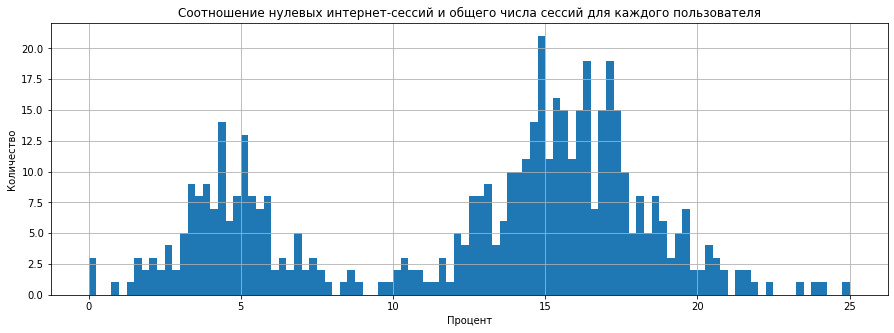

In [27]:
null_ratio['ratio'].plot(kind='hist', bins=100, grid=True, figsize=(15,5))

plt.title('Соотношение нулевых интернет-сессий и общего числа сессий для каждого пользователя')
plt.ylabel('Количество')
plt.xlabel('Процент')
plt.show()

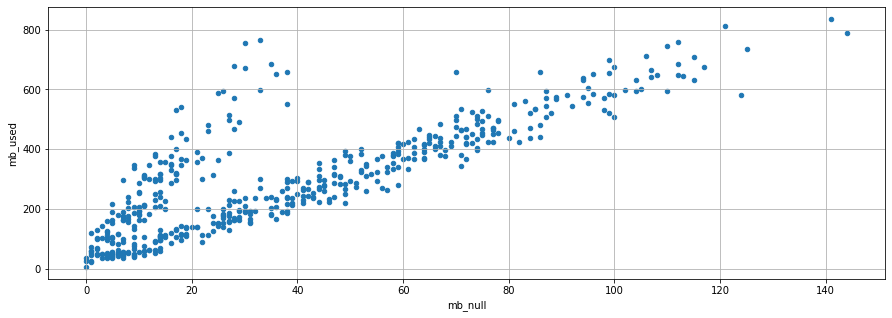

In [28]:
null_ratio.plot(kind='scatter', x='mb_null', y='mb_used', grid=True, figsize=(15,5))

На графиках очень смущает четкое разделение на две "кучи", причем у обеих "кучек" нормальное распределение - видимо, у их происхождения разные причины 
Возможно, первая кучка это исходящий трафик, а вторая - нетарифицируемый входящий (карты-навигаторы, мессенджеры и т.д)?

#### df_messages

In [29]:
df_messages.isna().sum()

id              0
message_date    0
user_id         0
dtype: int64

Преобразуем значения столбца message_date в тип datetime

In [30]:
df_messages['message_date'].describe()

count         123036
unique           364
top       2018-12-31
freq             859
Name: message_date, dtype: object

In [31]:
len(df_messages[df_messages['message_date'].isna()])

0

In [32]:
df_messages['message_date'] = pd.to_datetime(df_messages['message_date'], format="%Y-%m-%d")
df_messages['message_date'].describe()

count                  123036
unique                    364
top       2018-12-31 00:00:00
freq                      859
first     2018-01-02 00:00:00
last      2018-12-31 00:00:00
Name: message_date, dtype: object

#### df_tariffs

In [33]:
df_tariffs.isna().sum()

messages_included        0
mb_per_month_included    0
minutes_included         0
rub_monthly_fee          0
rub_per_gb               0
rub_per_message          0
rub_per_minute           0
tariff_name              0
dtype: int64

#### df_users

In [34]:
df_users.isna().sum()

user_id         0
age             0
churn_date    462
city            0
first_name      0
last_name       0
reg_date        0
tariff          0
dtype: int64

Преобразуем значения столбцов churn_date и reg_date в тип datetime

In [35]:
df_users['churn_date'].describe()

count             38
unique            33
top       2018-10-03
freq               2
Name: churn_date, dtype: object

In [36]:
df_users['churn_date'] = pd.to_datetime(df_users['churn_date'], format="%Y-%m-%d")
df_users['churn_date'].describe()

count                      38
unique                     33
top       2018-10-03 00:00:00
freq                        2
first     2018-08-17 00:00:00
last      2018-12-30 00:00:00
Name: churn_date, dtype: object

In [37]:
df_users['reg_date'].describe()

count            500
unique           270
top       2018-05-28
freq               8
Name: reg_date, dtype: object

In [38]:
df_users['reg_date'] = pd.to_datetime(df_users['reg_date'], format="%Y-%m-%d")
df_users['reg_date'].describe()

count                     500
unique                    270
top       2018-05-28 00:00:00
freq                        8
first     2018-01-01 00:00:00
last      2018-12-31 00:00:00
Name: reg_date, dtype: object

Для единообразия переименуем столбец tariff

In [39]:
df_users = df_users.rename(columns={'tariff':'tariff_name'})

### Расчеты

Посчитайте для каждого пользователя:
* количество сделанных звонков и израсходованных минут разговора по месяцам
* количество отправленных сообщений по месяцам
* объем израсходованного интернет-трафика по месяцам
* помесячную выручку с каждого пользователя (вычтите бесплатный лимит из суммарного количества звонков, сообщений и интернет-трафика; остаток умножьте на значение из тарифного плана; прибавьте абонентскую плату, соответствующую тарифному плану)

#### Количество звонков и минут

In [40]:
df_calls['month'] =  df_calls['call_date'].dt.month

In [41]:
df_user_calls = df_calls\
                .groupby(['user_id', 'month'])\
                .agg({'duration':'sum', 'id':'count'})\
                .reset_index()\
                .rename(columns={'id':'total_calls_count'})

In [42]:
df_user_calls.head()

,user_id,month,duration,total_calls_count
0,1000,5,159,22
1,1000,6,172,43
2,1000,7,340,47
3,1000,8,408,52
4,1000,9,466,58


In [43]:
df_user_calls['duration'].describe()

count    3174.000000
mean      456.931632
std       238.031270
min         0.000000
25%       290.000000
50%       447.000000
75%       592.000000
max      1673.000000
Name: duration, dtype: float64

In [44]:
df_user_calls['total_calls_count'].describe()

count    3174.000000
mean       63.833333
std        32.678036
min         1.000000
25%        41.000000
50%        63.000000
75%        83.000000
max       244.000000
Name: total_calls_count, dtype: float64

#### Количество сообщений

In [45]:
df_messages['month'] =  df_messages['message_date'].dt.month

In [46]:
df_user_messages = df_messages\
                    .groupby(['user_id', 'month'])\
                    .agg({'id':'count'})\
                    .reset_index()\
                    .rename(columns={'id':'total_messages_count'})

In [47]:
df_user_messages.head()

,user_id,month,total_messages_count
0,1000,5,22
1,1000,6,60
2,1000,7,75
3,1000,8,81
4,1000,9,57


#### Количество трафика

In [48]:
df_internet['month'] =  df_internet['session_date'].dt.month

In [49]:
df_user_internet = df_internet\
                    .groupby(['user_id', 'month'])\
                    .agg({'mb_used':'sum'})\
                    .reset_index()\
                    .rename(columns={'mb_used':'total_mb_used'})

In [50]:
df_user_internet.head()

,user_id,month,total_mb_used
0,1000,5,2253.49
1,1000,6,23233.77
2,1000,7,14003.64
3,1000,8,14055.93
4,1000,9,14568.91


#### Объединение таблиц

Объединим таблицы df_user_calls, df_user_messages и df_user_internet по столбцам user_id и month

In [51]:
df = df_user_calls.merge(df_user_messages, on=['user_id','month'], how='outer')

In [52]:
df = df.merge(df_user_internet, on=['user_id','month'], how = 'outer')

Добавим к ним информацию из столбцов df_users и df_tariffs

In [53]:
df = df.merge(df_users, on='user_id', how='left')

In [54]:
df = df.merge(df_tariffs, on='tariff_name', how='left')

Получили общую таблицу со всей необходимой информацией

In [55]:
df.head()

,user_id,month,duration,total_calls_count,total_messages_count,total_mb_used,age,churn_date,city,first_name,last_name,reg_date,tariff_name,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute
0,1000,5,159.0,22.0,22.0,2253.49,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000,30720,3000,1950,150,1,1
1,1000,6,172.0,43.0,60.0,23233.77,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000,30720,3000,1950,150,1,1
2,1000,7,340.0,47.0,75.0,14003.64,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000,30720,3000,1950,150,1,1
3,1000,8,408.0,52.0,81.0,14055.93,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000,30720,3000,1950,150,1,1
4,1000,9,466.0,58.0,57.0,14568.91,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000,30720,3000,1950,150,1,1


Проверим пропуски в общей таблице

In [56]:
df.isna().sum()

user_id                     0
month                       0
duration                   40
total_calls_count          40
total_messages_count      497
total_mb_used              11
age                         0
churn_date               3027
city                        0
first_name                  0
last_name                   0
reg_date                    0
tariff_name                 0
messages_included           0
mb_per_month_included       0
minutes_included            0
rub_monthly_fee             0
rub_per_gb                  0
rub_per_message             0
rub_per_minute              0
dtype: int64

Заполним пропуски нулями (кроме столбца churn_date)

In [57]:
df['duration'] = df['duration'].fillna(0)
df['total_calls_count'] = df['duration'].fillna(0)
df['total_messages_count'] = df['total_messages_count'].fillna(0)
df['total_mb_used'] = df['total_mb_used'].fillna(0)

In [58]:
df.duplicated().sum()

0

#### Помесячная выручка

In [59]:
def revenue(row):
    messages = (row['total_messages_count'] - row['messages_included']) * row['rub_per_message']
    calls = (row['duration'] - row['minutes_included']) * row['rub_per_minute']
    traffic = np.ceil((row['total_mb_used'] - row['mb_per_month_included']) /1024) * row['rub_per_gb']
    
    total = 0
    for i in [messages, calls, traffic]:
        if i > 0:
            total += i
    return total

In [60]:
df['revenue'] = df.apply(lambda x: revenue(x), axis=1)

In [61]:
df['total_revenue'] = df['revenue'] + df['rub_monthly_fee']

In [62]:
df = df.drop(columns = ['first_name', 'last_name', 'messages_included', 'mb_per_month_included', 'minutes_included', 
                        'rub_monthly_fee', 'rub_per_gb', 'rub_per_message', 'rub_per_minute'],axis = 1)

df['revenue'] = df['revenue'].astype(int)
df['total_revenue'] = df['total_revenue'].astype(int)

In [63]:
df.sort_values(by='total_revenue').head()

,user_id,month,duration,total_calls_count,total_messages_count,total_mb_used,age,churn_date,city,reg_date,tariff_name,revenue,total_revenue
2127,1340,1,25.0,25.0,0.0,2207.26,50,NaT,Пенза,2018-01-30,smart,0,550
2982,1468,11,276.0,276.0,13.0,12737.04,29,NaT,Тамбов,2018-02-11,smart,0,550
2318,1373,1,0.0,0.0,28.0,9173.74,34,NaT,Улан-Удэ,2018-01-17,smart,0,550
829,1134,2,458.0,458.0,47.0,13052.89,65,NaT,Красноярск,2018-01-16,smart,0,550
1721,1275,12,364.0,364.0,17.0,14796.81,48,NaT,Москва,2018-04-24,smart,0,550


In [64]:
df.sort_values(by='total_revenue').tail()

,user_id,month,duration,total_calls_count,total_messages_count,total_mb_used,age,churn_date,city,reg_date,tariff_name,revenue,total_revenue
1793,1286,12,739.0,739.0,68.0,35108.07,19,NaT,Москва,2018-11-27,smart,4771,5321
1622,1261,12,1074.0,1074.0,22.0,32650.91,46,NaT,Казань,2018-10-30,smart,5122,5672
3105,1486,11,764.0,764.0,96.0,36266.11,35,NaT,Нижний Новгород,2018-10-31,smart,5130,5680
260,1042,12,728.0,728.0,75.0,37165.69,42,NaT,Хабаровск,2018-11-25,smart,5159,5709
3106,1486,12,1007.0,1007.0,83.0,38552.45,35,NaT,Нижний Новгород,2018-10-31,smart,6220,6770


## Анализ данных

Опишите поведение клиентов оператора, исходя из выборки.  
Сколько минут разговора, сколько сообщений и какой объём интернет-трафика требуется пользователям каждого тарифа в месяц?  
Посчитайте среднее количество, дисперсию и стандартное отклонение.  
Постройте гистограммы. Опишите распределения.

### Минуты разговора

Рассчитаем среднее и медианное значение, дисперсию и стандартное отклонение для всех месяцев и для каждого месяца отдельно

In [65]:
df.pivot_table(
    index='tariff_name', 
    values='duration', 
    aggfunc=['median','mean','var','std','sum'])\
    .droplevel(1, axis=1).style.format("{:.2f}")

,median,mean,var,std,sum
tariff_name,,,,,
smart,422.00,417.93,36219.32,190.31,931577.00
ultra,518.00,526.62,100873.63,317.61,518724.00


In [66]:
df.pivot_table(
    index=['month', 'tariff_name'], 
    values='duration', 
    aggfunc=['median','mean','var','std','sum'])\
    .droplevel(1, axis=1).style.format("{:.2f}")

Рассчитаем длительность звонков в месяц для каждого пользователя

In [67]:
df_total_calls = df.pivot_table(
    index=['user_id', 'month', 'tariff_name'], 
    values='duration', 
    aggfunc=['sum']).droplevel(1, axis=1)

df_total_calls.head(10)

sum
user_id month tariff_name       
1000    5     ultra        159.0
        6     ultra        172.0
        7     ultra        340.0
        8     ultra        408.0
        9     ultra        466.0
        10    ultra        350.0
        11    ultra        338.0
        12    ultra        333.0
1001    11    smart        430.0
        12    smart        414.0

Построим диаграмму длительности звонков для обоих тарифов

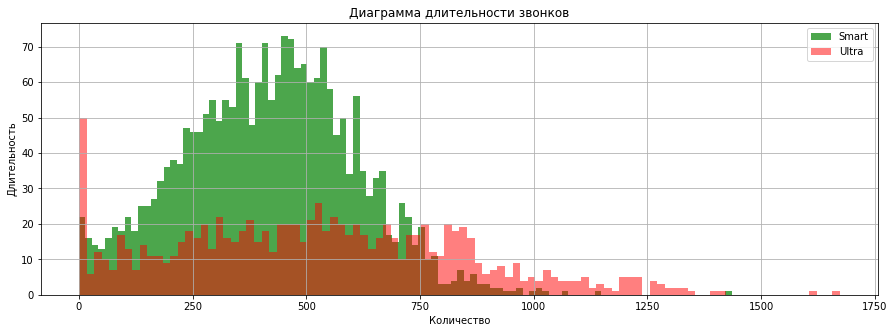

In [68]:
df_total_calls\
    .query('tariff_name == "smart"')['sum']\
    .plot(kind='hist', bins=100, alpha=0.7, color='green', grid=True, figsize=(15,5), label ='Smart')

df_total_calls\
    .query('tariff_name == "ultra"')['sum']\
    .plot(kind='hist', bins=100, alpha=0.5, color='red', grid=True, figsize=(15,5), label ='Ultra')

plt.title('Диаграмма длительности звонков')
plt.xlabel('Количество')
plt.ylabel('Длительность')
plt.legend()
plt.show()

Наблюдаются выбросы около нуля, в целом длительность звонком распределена по Пуассону

### Сообщения

Рассчитаем среднее и медианное значение, дисперсию и стандартное отклонение для всех месяцев и для каждого месяца отдельно

In [69]:
df.pivot_table(
    index='tariff_name', 
    values='total_messages_count', 
    aggfunc=['median','mean','var','std','sum'])\
    .droplevel(1, axis=1).style.format("{:.2f}")

,median,mean,var,std,sum
tariff_name,,,,,
smart,28.00,33.38,796.81,28.23,74413.00
ultra,38.00,49.36,2285.27,47.80,48623.00


In [70]:
df.pivot_table(
    index=['month', 'tariff_name'], 
    values='total_messages_count', 
    aggfunc=['median','mean','var','std','sum'])\
    .droplevel(1, axis=1).style.format("{:.2f}")

Рассчитаем количество сообщений в в месяц для каждого пользователя

In [71]:
df_total_messages = df.pivot_table(
    index=['user_id', 'month', 'tariff_name'], 
    values='total_messages_count', 
    aggfunc=['sum']).droplevel(1, axis=1)
df_total_messages.head(10)

sum
user_id month tariff_name      
1000    5     ultra        22.0
        6     ultra        60.0
        7     ultra        75.0
        8     ultra        81.0
        9     ultra        57.0
        10    ultra        73.0
        11    ultra        58.0
        12    ultra        70.0
1001    11    smart         0.0
        12    smart         0.0

Построим диаграмму количества сообщений для обоих тарифов

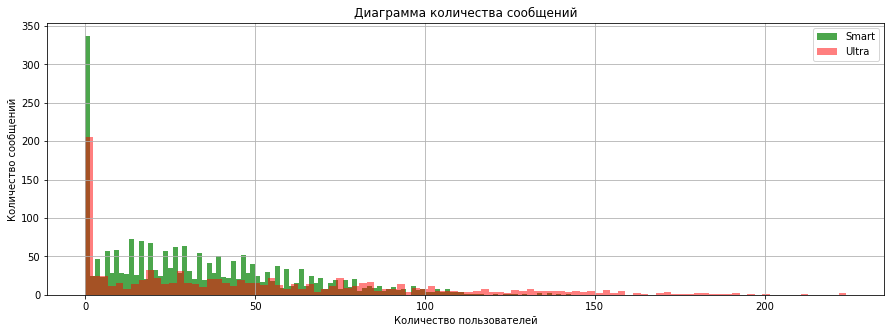

In [91]:
df_total_messages\
    .query('tariff_name == "smart"')['sum']\
    .plot(kind='hist', bins=100, alpha=0.7, color='green', grid=True, figsize=(15,5), label='Smart')

df_total_messages\
    .query('tariff_name == "ultra"')['sum']\
    .plot(kind='hist', bins=100, alpha=0.5, color='red', grid=True, figsize=(15,5), label='Ultra')

plt.title('Диаграмма количества сообщений')
plt.xlabel('Количество пользователей')
plt.ylabel('Количество сообщений')
plt.legend()
plt.show()

Наблюдаются выбросы около нуля, в целом количество сообщений распределено по Пуассону

### Трафик

Рассчитаем среднее и медианное значение, дисперсию и стандартное отклонение для всех месяцев и для каждого месяца отдельно

In [73]:
df.pivot_table(
    index='tariff_name', 
    values='total_mb_used', 
    aggfunc=['median', 'mean', 'var', 'std', 'sum'])\
    .droplevel(1, axis=1).style.format("{:.2f}")

,median,mean,var,std,sum
tariff_name,,,,,
smart,16506.84,16208.39,34462496.46,5870.48,36128494.60
ultra,19308.01,19468.81,101751013.78,10087.17,19176773.13


In [74]:
df.pivot_table(
    index=['month', 'tariff_name'], 
    values='total_mb_used', 
    aggfunc=['median','mean','var','std','sum'])\
    .droplevel(1, axis=1).style.format("{:.2f}")

Рассчитаем количество использованного интернет-трафика в месяц для каждого пользователя

In [75]:
df_total_traffic = df.pivot_table(
    index=['user_id', 'month', 'tariff_name'], 
    values='total_mb_used', 
    aggfunc=['sum']).droplevel(1, axis=1)
df_total_traffic.head()

sum
user_id month tariff_name          
1000    5     ultra         2253.49
        6     ultra        23233.77
        7     ultra        14003.64
        8     ultra        14055.93
        9     ultra        14568.91

Построим диаграмму количество трафика для обоих тарифов

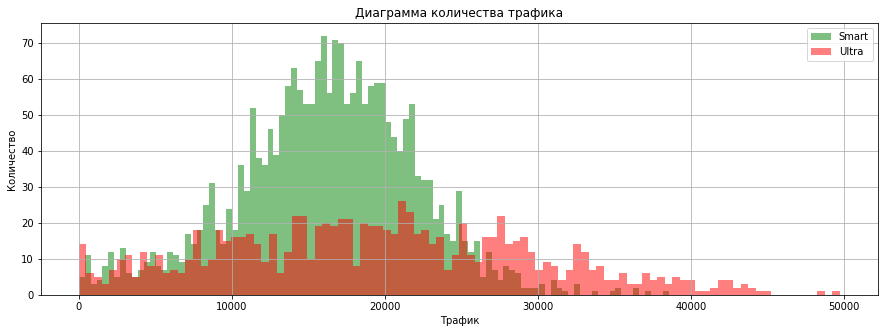

In [76]:
df_total_traffic\
    .query('tariff_name == "smart"')['sum']\
    .plot(kind='hist', bins=100, grid=True, figsize=(15,5), alpha=0.5, color='green', label='Smart')

df_total_traffic\
    .query('tariff_name == "ultra"')['sum']\
    .plot(kind='hist', bins=100, grid=True, figsize=(15,5), alpha=0.5, color='red', label='Ultra')

plt.title('Диаграмма количества трафика')
plt.xlabel('Трафик')
plt.ylabel('Количество')
plt.legend()
plt.show()

Наблюдаются выбросы около нуля, в целом трафик имеет нормальное распределение

## Проверка гипотез

* средняя выручка пользователей тарифов «Ультра» и «Смарт» различается
* средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов

Пороговое значение alpha задайте самостоятельно.

Поясните:
* как вы формулировали нулевую и альтернативную гипотезы
* какой критерий использовали для проверки гипотез и почему

Когда генеральных совокупностей две, бывает нужно сопоставить их средние.

Чтобы проверить гипотезу о равенстве среднего двух генеральных совокупностей по взятым из них выборкам, примените метод scipy.stats.ttest_ind().

Методу передают параметры: array1 , array2 — массивы, содержащие выборки; equal_var — необязательный параметр, задающий считать ли равными дисперсии выборок.

### Средняя выручка пользователей тарифов «Ультра» и «Смарт» различается

Сформулируем нулевую и альтернативную гипотезы:  
H0 = средняя выручка пользователей тарифов «Ультра» и «Смарт» равна  
H1 = средняя выручка пользователей тарифов «Ультра» и «Смарт» различается

In [77]:
ultra = df.query('tariff_name == "ultra"')['total_revenue']
smart = df.query('tariff_name == "smart"')['total_revenue']

In [78]:
alpha = 0.05

results = st.ttest_ind(
            smart, ultra)

results.pvalue

1.4229814360764067e-160

In [79]:
if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Нулевая гипотеза не может быть отвергнута")

Отвергаем нулевую гипотезу


Рассчитаем среднюю выручку для каждого тарифа и общую прибыль

In [80]:
smart.mean()

1289.9735307312696

In [81]:
ultra.mean()

2070.1522842639592

In [82]:
smart.sum()

2875351

In [83]:
ultra.sum()

2039100

### Средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов

Сформулируем нулевую и альтернативную гипотезы:  
H0 = средняя выручка жителей Москвы и других городов равна  
H1 = средняя выручка жителей Москвы и других городов различается

In [84]:
moscow = df.query('city == "Москва"')['total_revenue']
russia = df.query('city != "Москва"')['total_revenue']

In [85]:
alpha = 0.05


results = st.ttest_ind(
            moscow, russia)

results.pvalue

0.5440152911670224

In [86]:
if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Нулевая гипотеза не может быть отвергнута")

Нулевая гипотеза не может быть отвергнута


In [87]:
moscow.mean()

1546.7135842880523

In [88]:
moscow.sum()

945042

In [89]:
russia.mean()

1524.9362274298885

In [90]:
russia.sum()

3969409

## Общий вывод

* Присутствуют пользователи, которые не пользуются всеми возможностями тарифа (нулевые значения)  
* У пользователей тарифа Ультра в среднем дольше звонки, больше сообщений и интернет-трафика
  * Смарт: 422 минуты разговоров, 28 сообщений, 16,1 Гб трафика
  * Ультра: 518 минут разговоров, 38 сообщений, 18,9 Гб трафика
* Средняя выручка на тарифе Смарт отличается от выручки на тарифе Ультра, при этом общая выручка тарифа Смарт выше (т.к. больше пользователей)
  * Смарт: 1230.2 средняя, 2 742 018 общая
  * Ультра: 2059.8 средняя, 2 028 903 общая
* Средняя выручка от жителей Москвы и других городов практически не отличается, хотя львиную долю прибыли дает остальная Россия:
  * Москва: 1505 средняя, 919 579 общая
  * Россия: 1479.6 средняя, 3 851 342 общая

Общая выручка тарифа Смарт выше (т.к. больше пользователей)
У Смарта базовый тариф стоит 550 рублей, при этом средняя выручка с этого тарифа - 1230, у Ультры базовый тариф 1950, а средняя выручка 2060
Получается, что многие пользователи Ультры "не добирают" свой тариф, им хватает базового, при этом на Смарте пользователи выходят за рамки тарифа и приносят больше прибыли

Хотя стоимость тарифа Ультра и значительно выше Смарта, более выгоден оператору тариф Смарт